# HHVM

## 背景介绍

HHVM 是 Facebook (现 Meta) 开发的高性能 PHP 虚拟机，宣称达到了官方解释器的 9x 性能

### 为什么会有 HHVM

#### 脚本语言


##### Pros

一般我们使用脚本语言 （Perl，Python，PHP，JavaScript）是为了以下几个目的

1. 大部分的脚本语言都拥有较为完备的外部库，能够帮助开发者快速的开发/测试

   - 使用 Python 作为 ebt 的技术栈也是因为 `numpy`, `pandas` 等数据科学库的支持比别的编程语言更加的完备

2. 动态语言的特性使得开发过程变得异常轻松，可以最大程度的实现可复用性和多态性，打个比方

   ```python
   def evaluate(model_impl, params):
       return model_impl.calculate(params)


   class Model(object):
       def calculate(params):
           sum_val = 0
           for param in params:
               sum_val += param

           return sum_val
   ```

   ```cpp
   class IModel {
       public:
           virtual double calculate(const vector<double> &params) = 0;
           virtual int calculate(const vector<int> &params) = 0;
   }

   class Model : public IModel {
       public:
           double calculate(const vector<double> &params) {
               double sum_val = 0;
               for (vector<double>::iterator it = params.begin(); it != params.end(); ++it) {
                   sum_val += *it;
               }
               return sum_val;
           }

           int calculate(const vector<int> &params) {
               int sum_val = 0;
               for (vector<int>::iterator it = params.begin(); it != params.end(); ++it) {
                   sum_val += *it;
               }
               return sum_val;
           }
   }

   double evaluate(IModel* model_impl, const vector<double> &params) {
       return model_impl->calculate(params);
   }

   int evaluate(IModel* model_impl, const vector<int> &params) {
       return model_impl->calculate(params);
   }
   ```

   - 模版

   ```cpp
   // This is ok but template is not a general feature for all static typed language
   template <typename T>
   T evaluate(IModel* model_impl, const vector<T> &params) {
       return model_impl->calculate<T>(params);
   }
   ```

3. 动态语言完全是解释执行，调试成本较低。每当改动源码有所改动后，程序重新运行更加直接，只需要解释器重新读取源码即可。编译性语言需要更多的步骤与时间，例如 C++，为了从源码生成可执行程序需要 链接静态库 -> .obj -> 链接动态库 -> 可执行程序。如果是大型项目开发的话这一步骤甚至会花费几个小时。而解释执行的程序可以不需要这些步骤直接重新运行


##### Cons

但是对于有较高性能需求的 situation，编译执行反而会成为拖累。

> Although easy to implement, interpreters are generally slow, which makes scripting language prohibitive for implementing large, CPU-intensive applications. (Zhao, 2021)

Debian 有一个 [benchmark game](https://benchmarksgame-team.pages.debian.net/benchmarksgame/index.html)，比较了目前比较常见的几种编程语言的运行速度/内存占用/源码大小

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
benchmarks = pd.read_csv('./data/programming_language_benchmarks_game_all_measurements.csv')

benchmarks.head(10)


,name,lang,id,n,size(B),cpu(s),mem(KB),status,load,elapsed(s),busy(s)
0,binarytrees,rust,2,7,721,0.004,0,0,0% 33% 0% 75%,0.091,0.098
1,binarytrees,rust,2,14,721,0.027,0,0,%,0.000,0.000
2,binarytrees,rust,2,21,721,4.286,199808,0,85% 88% 99% 87%,1.206,4.329
3,binarytrees,rust,2,21,721,4.387,175268,0,87% 86% 98% 88%,1.235,4.437
4,binarytrees,rust,2,21,721,4.414,199704,0,87% 99% 88% 87%,1.234,4.457
5,binarytrees,rust,2,21,721,4.271,199760,0,88% 87% 99% 87%,1.201,4.333
6,binarytrees,rust,2,21,721,4.315,199756,0,87% 86% 99% 85%,1.220,4.365
7,binarytrees,rust,2,21,721,4.297,199848,0,88% 88% 98% 88%,1.207,4.369
8,binarytrees,ghc,8,7,799,0.009,8,0,67% 10% 60% 23%,0.207,0.330
9,binarytrees,ghc,8,14,799,0.047,0,0,50% 100% 50% 50%,0.024,0.061


In [27]:
compile_lang_lst = ['clang', 'csharpcore', 'csharppgo', 'gcc', 'gfortran', 'go', 'gpp', 'java', 'rust', 'swift']
interpreter_lang_lst = ['node', 'perl', 'php', 'python3']

def boxplot_by_lang(data: pd.DataFrame, colname: str) -> None:
    fig, ax = plt.subplots()
    index = 1
    for lang in compile_lang_lst:
        ax.boxplot(data[data['lang'] == lang][colname],
                   positions=[index],
                   labels=[lang],
                   boxprops=dict(color='blue'))
        index += 1

    for lang in interpreter_lang_lst:
        ax.boxplot(data[data['lang'] == lang][colname],
                   positions=[index],
                   labels=[lang],
                   boxprops=dict(color='green'))
        index += 1

    ax.set_title(colname, fontsize=15)
    ax.tick_params(axis='x', labelrotation=45)
    fig.set_size_inches(10, 6)

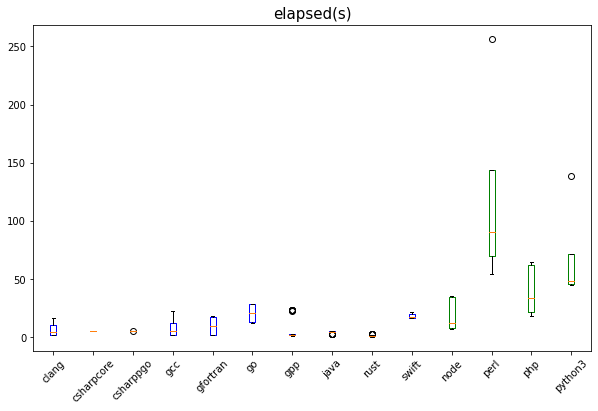

In [28]:
filtered = benchmarks[(benchmarks['status'] == 0) & (benchmarks['name'] == 'binarytrees') & (benchmarks['n'] == 21)].reset_index()
boxplot_by_lang(data=filtered, colname='elapsed(s)')

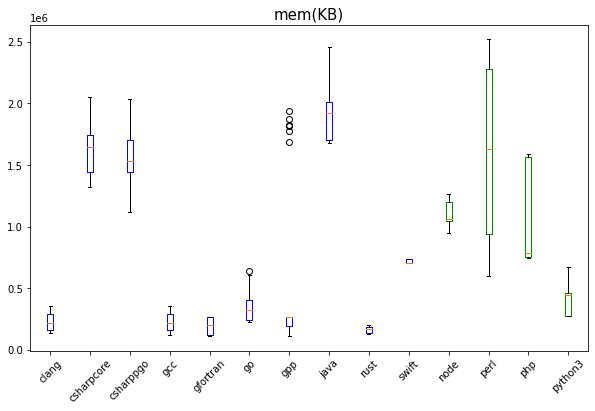

In [30]:
boxplot_by_lang(data=filtered, colname='mem(KB)')


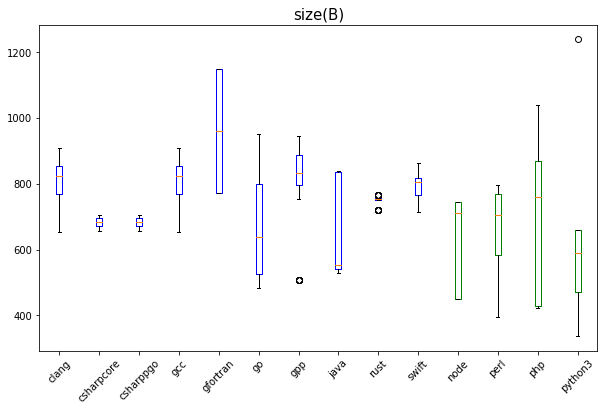

In [31]:
boxplot_by_lang(data=filtered, colname='size(B)')


通过以上数据可以显然看出与编译执行语言相比，解释执行的语言在 CPU 的处理性能有明显的优势，部分编译执行的语言在内存处理（申请与回收）上也有着异常优秀的表现。

像 Meta 这样的巨型公司需要 host 的服务器是也是巨型的

![facebook_datacenter](./images/faceboook_datacenter_oregon.png)

上图是 Meta 在 Oregon 的数据中心，据说这两个 building 的造价就高达了 *$750M* (约合 *¥47.78 亿*)，并且在 2020 年中 Meta 又在边上造了两个

如此巨型的数据中心的一大作用就是用来做 Facebook 的服务器主机，所以为了优化服务器的物理成本，从代码上优化服务器性能是必然的。

我们都知道 Facebook 是用 PHP 实现的，据 HHVM 的项目主持者之一的 Keith Adams 所说，Facebook 有约莫 $2 \times 10^7$ 行 PHP 代码 （2012年）。Facebook 的开发者在检查之后发现自己服务器的性能问题很大一部分就是资源的消耗就在 PHP 的解释器本身上，所以需要考虑的就是如何优化 PHP 的性能

### 如何优化 PHP 的性能

1. 使用性能更好的语言重写服务端，如 C++，GO，Java
    - 重构2千万行代码？算了算了

2. 使用 RPC 将部分业务功能独立，减少 PHP 的处理，比如 Twitter 就将自己的很多业务逻辑从 Ruby on Rails 转为了 Java 和 Scala (前端由 node + react 独立实现)
![twitter_tech_stack](./images/twitter_tech_stack.webp)
   - RPC 框架 
        ![Thrift](./images/Thrift_homepage.png)

    但是不解决问题


3. 以动态扩展的形式优化 PHP 的性能瓶颈，用 PHP 加载 C++ 实现的方式绕开性能瓶颈
    - ebt 目前的解决方案，但是对 Facebook 这样历史包袱过重的源码仓库来说，性能瓶颈并不是 1-2 处小地方，而是不断累积的后果，并且 PHP 的扩展并不像 pybind 一样有比较成熟的加载方式

4. 优化 PHP 的解释器本身


### 如何优化 PHP 的解释器

1. 改进自己的源码
   - 用 PHP 写的 PHP 性能分析工具 [XHProf](https://github.com/phacility/xhprof)
   - 定位性能瓶颈处，优化代码逻辑，就像 leetcode 去做到 >99%
   - 优化的不够

2. 优化 PHP 的解释器实现
   - [Zend Engine](https://github.com/php/php-src/tree/master/Zend)
   - 将 PHP 编译为 `opcode` 然后执行 `opcode`
   - 优化 Zend 的性能代价太大，并且还要做到版本的向下兼容

3. 将 PHP 转为 C/C++，然后编译生成
   - Hiphop Compiler for PHP (Zhao, 2012)
    ![Hiphop_gen](./images/hhvm_autogen.png)